In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(37)
np.random.seed(37)

from scipy.signal import detrend

In [ ]:
! cp /content/drive/MyDrive/Colab\ Notebooks/transient_detection/gps_signal.py .
from gps_signal import transient, seasonal, colored_noise, outliers

In [ ]:
home_dir = '/content/drive/MyDrive/Colab Notebooks/transient_detection/'

In [ ]:
def snr(d_signal, d_noise):
  std_signal = np.std(d_signal)
  std_noise = np.std(d_noise)
  return 10*np.log10((std_signal/std_noise)**2)


def random_noise(nt, noise_type=0):
  if noise_type == 0:
    d_seasonal = seasonal(nt, [4.5,6.9], [0.7,1.5])
    d_noise = colored_noise(nt, [2.0, 2.9], [2.3, 5.9], [0, 2.9])
    d_outliers = outliers(nt, 10, 0.05)
  else:
    d_seasonal = seasonal(nt, [1,2], [0.2,0.5])
    d_noise = colored_noise(nt, [0.4, 0.9], [0.3, 1.6], [0, 1.4])
    d_outliers = outliers(nt, 5, 0.05)
  return d_seasonal + d_noise + d_outliers


def make_dataset(nt, event_num, noise_type=0, label_snr_threshold=None):

  label = np.zeros(nt)

  #
  d_noise = random_noise(nt, noise_type)

  #
  n_event = np.random.choice(event_num)
  event_window_len = nt/n_event
  d_transient = 0
  for i in range(n_event):
    size = np.random.choice([-1,1])*20*np.random.rand()
    duration = 5 + 25*np.random.rand()
    center = i*event_window_len + 20 + (event_window_len - 40)*np.random.rand()
    d_transient += transient(nt,size,duration,center)

    index_start = np.int(center - duration/2)
    index_stop = np.int(center + duration/2)
    if label_snr_threshold is None:
      label[index_start: index_stop] = 1
    else:
      if snr(d_transient[index_start: index_stop], d_noise[index_start: index_stop]) > label_snr_threshold:
        label[index_start: index_stop] = 1

  return d_transient + d_noise, label


In [ ]:
from sklearn.preprocessing import minmax_scale
def scale(data):
  return minmax_scale(detrend(data, axis=1), axis=1)

In [ ]:
nt = 200

In [ ]:
n_train_sample = 10000
train_data = np.zeros((n_train_sample, nt))
train_label = np.zeros((n_train_sample, nt))

for i in range(n_train_sample):
  train_data[i,:], train_label[i,:] = make_dataset(nt, event_num=[0,1,2,3], noise_type=i%3, label_snr_threshold=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in long_scalars


In [ ]:
train_data = scale(train_data)

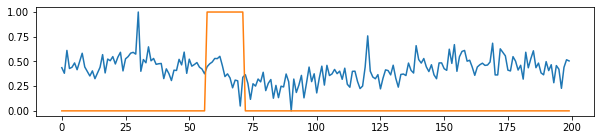

In [ ]:
i = 50
plt.figure(figsize=(10,2))
plt.plot(train_data[i,:])
plt.plot(train_label[i,:])
plt.show()

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking

In [ ]:
def init_model():
  model = Sequential()
  model.add(Masking(input_shape=(None, 1)))
  model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True)))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  #model.compile(loss='binary_crossentropy', optimizer='adam')
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),loss=tf.losses.BinaryCrossentropy())
  return model

In [ ]:
model = init_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 1)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          8704      
_________________________________________________________________
dense_2 (Dense)              (None, None, 16)          1040      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           17        
Total params: 9,761
Trainable params: 9,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data[:,:, np.newaxis], train_label[:,:, np.newaxis], validation_split=0.1, epochs=20, batch_size=256)

Epoch 1/20
36/36 [==============================] - 31s 857ms/step - loss: 0.0653 - val_loss: 0.0703
Epoch 2/20
36/36 [==============================] - 31s 866ms/step - loss: 0.0638 - val_loss: 0.0694
Epoch 3/20
36/36 [==============================] - 31s 868ms/step - loss: 0.0636 - val_loss: 0.0742
Epoch 4/20
36/36 [==============================] - 31s 863ms/step - loss: 0.0653 - val_loss: 0.0714
Epoch 5/20
36/36 [==============================] - 31s 868ms/step - loss: 0.0638 - val_loss: 0.0698
Epoch 6/20
36/36 [==============================] - 31s 857ms/step - loss: 0.0637 - val_loss: 0.0695
Epoch 7/20
36/36 [==============================] - 32s 876ms/step - loss: 0.0638 - val_loss: 0.0716
Epoch 8/20
36/36 [==============================] - 31s 873ms/step - loss: 0.0647 - val_loss: 0.0730
Epoch 9/20
36/36 [==============================] - 31s 854ms/step - loss: 0.0701 - val_loss: 0.0813
Epoch 10/20
36/36 [==============================] - 32s 882ms/step - loss: 0.0724 - val_lo

In [ ]:
model.save(home_dir+'sequence_model_0_mask.h5')

Evaluation

In [ ]:
train_pred = np.squeeze(model.predict(train_data[:, :, np.newaxis]))

In [ ]:
i = 9769

plt.figure(figsize=(15,3))
plt.plot(train_data[i,:])
plt.plot(train_label[i,:])
plt.plot(train_pred[i,:])
plt.show()

Test false positive rate using nosie data for determining the label_snr_threshold

In [ ]:
n_test_sample = 10000
test_data = np.zeros((n_test_sample, nt))
test_label = np.zeros((n_test_sample, nt))
for i in range(n_test_sample):
  test_data[i,:] = random_noise(nt, noise_type = i%3)

test_data = scale(test_data)

In [ ]:
test_pred = np.squeeze(model.predict(test_data[:,:, np.newaxis]))

In [ ]:
print('Iterations with no false: {:.0f}/10000'.format(len(np.nonzero(np.all(test_pred<0.5, axis=1))[0])))
print('Total false points: {:.4%}'.format(len(np.nonzero(test_pred>0.5)[0])/(n_test_sample*nt)))

In [ ]:
index_wrong=np.nonzero(np.any(test_pred>0.5, axis=1))[0]
len(index_wrong)

In [ ]:
i = index_wrong[6]
plt.figure(figsize=(15,3))
plt.plot(test_data[i,:])
plt.plot(test_pred[i,:])
plt.show()

How much the offset is of each SNR value?

In [ ]:
# d_noise = colored_noise(30, [2.0, 2.9], [2.3, 5.9], [0, 2.9])
d_noise = colored_noise(nt, [0.4, 0.9], [0.3, 1.6], [0, 1.4])
d_signal = transient(30,0.5,30,15)

snr(d_signal, d_noise)